# Pytorch Workflow

In [45]:
import torch
from torch import nn #nn contains all Pytorch's building blocks for neural networks
import matplotlib.pyplot as plt


torch.__version__

'2.0.0+cu118'

## Prepare and Load data
excel, imgs, video, audio, text, whatever

We can separate machine learning into two big categories:
1. Get data into a numerical represintation.
2. Build a model to learn patterns in that numerical repr.

Lets start with a linear regression: we'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [46]:
# Create *known parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
# input
X = torch.arange(start, end, step).unsqueeze(dim=1)
# output
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [47]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets(one of the most important concepts in ML)

In [48]:
# Create test and training sets

# first lets create percentage of data split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [49]:
# plot (vizualise) our training data

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None
                    ):
  """
  Plots training and test data, compares predictions
  """
  plt.figure(figsize=(7, 7))

  # plot training data in blue color
  plt.scatter(train_data, train_labels, c='b', s=10, label='Training Data')

  # plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=10, label='Testing Data')

  # are there any predictions?
  if predictions is not None:
    # plot them against our test data if exist
    plt.scatter(test_data, predictions, c='r', s=10, label='Predictions')

  # show the legens
  plt.legend(prop={'size': 14})

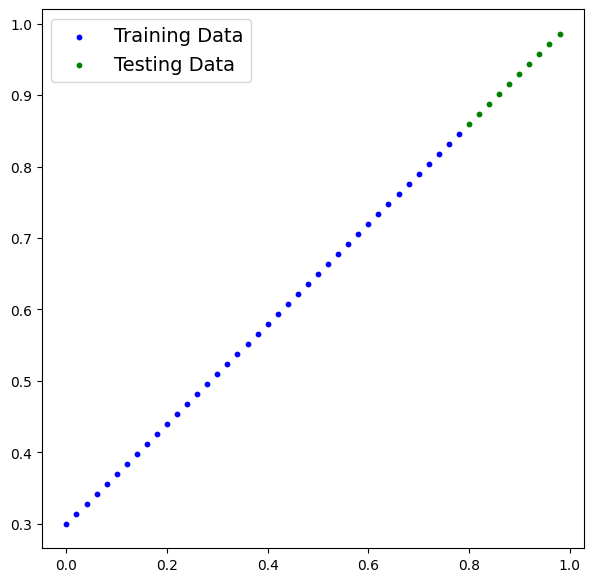

In [50]:
plot_predictions()

## Building first PyTorch model

In [51]:
# Create liner regression model class

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(1,  # -> nn.Parameter <- tensor, which is to be considered as module parameter, will appear in ~Module.parameters iterator
                                          requires_grad=True, # <- default1
                                          dtype=torch.float
                                          ))
    self.bias = nn.Parameter(torch.rand(1,
                                          requires_grad=True,
                                          dtype=torch.float
                                          ))
  # Forward mwthod to de4fine a computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x - input(training) data
    return self.weight * x + self.bias  #this is the linear regression formula

Whatthis model does:
* Start with random values (weight and bias)
* Look at training data and adjust the random numbers to get closer(or better represent) to ideal values ( the weight and bias values we used to create a data) 

How does it do so?
Trough two main algorithms:
1. Gradient descent: https://www.youtube.com/watch?v=IHZwWFHWa-w&t=10s
2. Backpropagation

Оба этих алгоритма уже написаны в pytorch и будут выполнены за меня, но все равно нужно знать как они работают!

### Checking the contents of our PyTorch model

check parameters with `.parameters()`

In [52]:
# Create a random seed (для наглядности)
torch.manual_seed(88)

# Create an instance of our model
model_0 = LinearRegressionModel()

model_0.parameters() #returns a generator

for i in model_0.parameters():
  print(i)

Parameter containing:
tensor([0.7731], requires_grad=True)
Parameter containing:
tensor([0.6937], requires_grad=True)


In [53]:
# List named params
model_0.state_dict()

OrderedDict([('weight', tensor([0.7731])), ('bias', tensor([0.6937]))])

### Making predictions using torch.inference_mode()

чтобы посмотреть как хорошо наша модель предугадывает что-либо, посмотрим как хорошо она предугадает y_test основываясь на X_test

Когда мы скармливаем данные моделе, она прогоняет их через forward() метод


In [54]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [57]:
# Make predictions with model, inference_mode() не возвращает градиент в отличие от метода ниже, к тому же делает код быстрее
with torch.inference_mode(): 
  y_preds = model_0(X_test)

y_preds

# другой способ:
# y_preds = model_0(X_test)

tensor([[1.3122],
        [1.3277],
        [1.3431],
        [1.3586],
        [1.3740],
        [1.3895],
        [1.4050],
        [1.4204],
        [1.4359],
        [1.4514]])

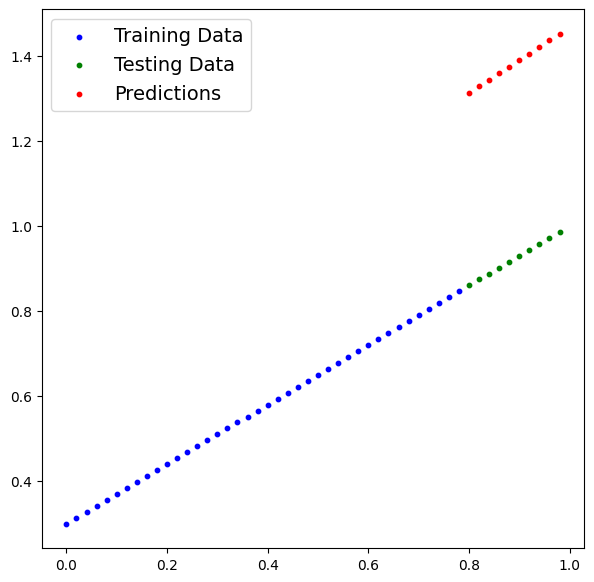

In [58]:
plot_predictions(predictions=y_preds)

## Train model

пока что результат ужасный, т.к. наша модель пока что инкак не подгоняет weight and bias под оптимальные значения.

Нам нужен способ измерить насколько плохо модель предугадывает значения - для этого существует `loss function`. Чем меньше значение - тем лучше.

loss function также может называться `cost function` или `criterion`

Thing we need to train:
* **Loss function**
* **Optimizer**: takes into account a loss of a model and adjusts the model's parameters (w and b) to improve a loss function

And specificaly for PyToech we need:
* A training loop
* A testing loop